<h1>Autoencoder Training</h1>
The filament picker uses a classifier to determine whether a part of the micrograph contains filaments or not. However, to properly train a classifier, you need to have a good feature generation pipeline. To do this automatically, we will train an autoencoder. <br>
Autoencoders contain both an encoder and a decoder, which compress an image into latent space and then inflate it, respectively. Once the autoencoder is trained and can return images that still contain the features we want classify later, we can extract the encoder part of the model and reuse it in the classifier, simplifying the training process.

<h2>Early Imports</h2>
Python packages needed to setup everything up. Tensorflow will be imported later.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import mrcfile
from sklearn.model_selection import train_test_split

<h3>Data normalizer</h3>
Data is standardized by subtracting the mean and dividing by the standard deviation. This is done per image basis.<br>
Values below are hard coded in for this version of the code (-7.5 and +7.5).

In [6]:
def normalizer(data):
    norm = (data - np.mean(data))/np.std(data)
    return (norm + 7.5)/15 #min is -7.5, max is +7.5 to achieve dynamic range
#7.5 and 29 give full range of numbers in the real dataset, but it's not really dynamic

In [7]:
files = glob.glob("holes/*.mrc")
#update the location as needed
number_of_files = len(files)
print(number_of_files)

136


<h3>Read data</h3>
Each image will be broken up into 64 by 64 segments. Since each image is about 924 x 924, there will be 14 x 14 full fragments. Edges are discarded.

In [8]:
subsets = np.zeros((196*number_of_files,64,64), dtype='float32')
#initializes the numpy array containing the fragments. 

In [9]:
for n, file in enumerate(files):
    f = mrcfile.open(file)
    data = normalizer(f.data)
    data[data > 1] = 1 #since we are normalizing by dynamic range rather than absolute range, we cap the values at 1. Can do the same for 0, but we used the absolute min in this case.
    for num in range(196):
        i = num//14
        j = num%14
        subsets[n*196+num] = data[(14+64*j):(14+64*(j+1)),(14+64*i):(14+64*(i+1))]
        #above code splits each image into 64 x 64 segments

In [10]:
subsets.shape

(26656, 64, 64)

In [11]:
subsets.dtype
#data type should be float32, otherwise convert to it. This is important when training using gpus.

dtype('float32')

In [12]:
s_min = np.min(subsets)
s_max = np.max(subsets)
print(s_min, s_max)
#Double checking the min and max values. Everything should be between 0 and 1.

0.007988358 1.0


In [13]:
print(np.mean(subsets))
print(np.std(subsets))

0.5007883
0.06585504


(array([5.0380000e+03, 1.2007600e+05, 7.4970200e+05, 6.8682690e+06,
        4.6275682e+07, 5.0666967e+07, 4.2062260e+06, 2.0890200e+05,
        6.5206000e+04, 1.6908000e+04]),
 array([0.00798836, 0.10718952, 0.20639068, 0.30559185, 0.40479302,
        0.50399417, 0.60319537, 0.7023965 , 0.80159765, 0.90079886,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

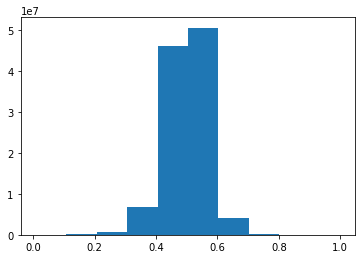

In [14]:
plt.hist(subsets.flatten())
#data should be using most of space between 0 and 1.

In [15]:
sub_reshape = subsets.reshape(-1, 64, 64, 1)
sub_reshape.shape
#not really neccesary, but tensorflow prefers this format to specify only 1 channel (grayscale) is being used

(26656, 64, 64, 1)

<h4>Note</h4>
Original training did not include data augmentation, but ideally this is something that should be included to improve training, especially for smaller datasets.

<h3>Model setup</h3>

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_x, valid_x, train_ground, valid_ground = train_test_split(sub_reshape, sub_reshape, test_size=0.2, random_state=42)
#Feel free to make the random state actually random. I fixed it so I could monitor changes with model architure changes.

In [18]:
batch_size = 512 #trained on a Nvidia GeForce 2060 with 6GB, batch size can be changed if needed
# epochs = 50
inChannel = 1
x, y = 64, 64

In [19]:
import tensorflow as tf
import tensorflow.keras as keras

In [20]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#this block is needed for some NVIDIA gpus to prevent memory errors. Might have gotten fixed in newer Tensorflow versions.

In [21]:
input_img = keras.Input(shape = (x, y, inChannel))

In [42]:
def autoencoder_feature(input_img):
    #encoder
    #input = 64 x 64 x 1
    conv1 = batch_conv(input_img, 32) #64 x 64 x 32
    pool1 = keras.layers.MaxPool2D(pool_size=(2,2))(conv1) #32 x 32 x 32
    conv2 = batch_conv(pool1, 64) #32 x 32 x 64
    pool2 = keras.layers.MaxPool2D(pool_size=(2,2))(conv2) #16 x 16 x 64
    conv3 = batch_conv(pool2, 128) #16 x 16 x 128
    conv3_1 = batch_conv(conv3, 64, (1,1)) #16 x 16 x 64
    conv3_2 = batch_conv(conv3_1, 128) #16 x 16 x 128
    pool3 = keras.layers.MaxPool2D(pool_size=(2,2))(conv3_2) #8 x 8 x 128
    conv4 = batch_conv(pool3, 256) #8 x 8 x 256
    conv4_1 = batch_conv(conv4, 128, (1,1)) #8 x 8 x 128
    conv4_2 = batch_conv(conv4_1, 256) #8 x 8 x 256
    #decoder
    conv5 = batch_conv(conv4_2, 256) #8 x 8 x 256
    up1 = keras.layers.UpSampling2D((2,2))(conv5) #16 x 16 x 256
    conv6 = batch_conv(up1, 128) #16 x 16 x 128
    up2 = keras.layers.UpSampling2D((2,2))(conv6) #32 x 32 x 128
    conv7 = batch_conv(up2, 64) #32 x 32 x 54
    up3 = keras.layers.UpSampling2D((2,2))(conv7) #64 x 64 x 64
    decoded = keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(up3) #64 x 64 x 1
    return decoded

In [23]:
def batch_conv(input_img, channels, size=(3,3)):
    conv = keras.layers.Conv2D(channels, size, padding='same', use_bias=False)(input_img)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.ReLU()(conv)
    return conv

In [43]:
autoen = keras.Model(input_img, autoencoder_feature(input_img))
autoen.compile(loss='mean_squared_error', optimizer = keras.optimizers.RMSprop())

In [25]:
autoen.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        288       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256   

<h3>Model Training and evaluation</h3>
There's not a set number of epochs I use when training. About 300 epochs usually gives me good results, but I often like to train 50 epochs at a time, visualize the results, and then determine whether to continue or save the model.

In [44]:
autoencoder_train = autoen.fit(train_x, train_ground, batch_size=batch_size, epochs=50, verbose=1, validation_data=(valid_x, valid_ground))

Epoch 1/50
42/42 [==============================] - 12s 277ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 2/50
42/42 [==============================] - 12s 274ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 3/50
42/42 [==============================] - 12s 275ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 4/50
42/42 [==============================] - 12s 276ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 5/50
42/42 [==============================] - 12s 276ms/step - loss: 0.0031 - val_loss: 0.1391
Epoch 6/50
42/42 [==============================] - 12s 277ms/step - loss: 0.0030 - val_loss: 0.1316
Epoch 7/50
42/42 [==============================] - 12s 277ms/step - loss: 0.0029 - val_loss: 0.0975
Epoch 8/50
42/42 [==============================] - 12s 277ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 9/50
42/42 [==============================] - 12s 278ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 10/50
42/42 [==============================] - 12s 276ms/step - loss: 0.0024 - val_lo

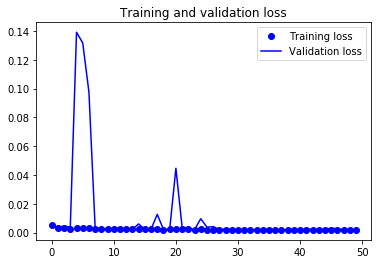

In [45]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_r = range(len(loss))
plt.plot(epochs_r, loss, 'bo', label='Training loss')
plt.plot(epochs_r, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#Let you visualize the loss to determine whether there's any improvement loss wise

In [46]:
pred = autoen.predict(valid_x)
pred.shape
#Test the model on either the validation data or some never before seen micrograph

(5332, 64, 64, 1)

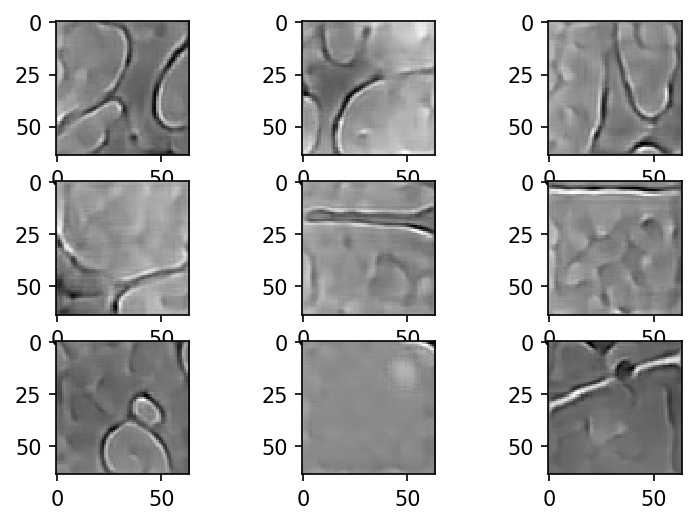

In [47]:
fig, axes = plt.subplots(3,3)
fig.set_dpi(150)
axes = axes.flatten()
for n, ax in enumerate(axes):
    tmp = pred[n+1000].reshape((64,64))
    ax.imshow(tmp.astype(float), cmap='gray')
#quick way to visualize a few segments at a time. Change the "n+1000" to a different value to see other segments

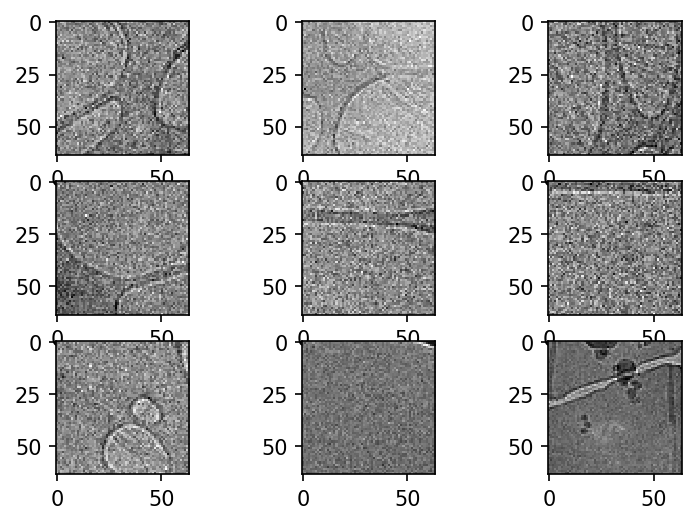

In [30]:
fig, axes = plt.subplots(3,3)
fig.set_dpi(150)
axes = axes.flatten()
for n, ax in enumerate(axes):
    tmp = valid_x[n+1000].reshape((64,64))
    ax.imshow(tmp.astype(float), cmap='gray')
#This one will show you the real segments to compare to the above ones.

In [153]:
autoen.save("autoencoder_enFeatures_512b_stdver")
#Save the model if you like the results

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: autoencoder_enFeatures_512b_stdver\assets


<h3>Testing full micrographs</h3>
Code below can be used to check how the autoencoder handles a full micrograph

In [65]:
autoen = keras.models.load_model('autoencoder_enFeatures_512b_stdver/')
#Load a saved model, or continue one from above

In [48]:
test_mrc = mrcfile.open("new_holes/20jan13b_atlas2_00047gr_00017sq_v02_00003hl.mrc")
#loads a test image. Best if the image was not included in the training dataset

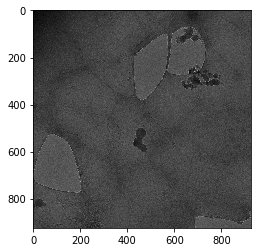

In [49]:
plt.imshow(test_mrc.data, cmap='gray')

In [50]:
big_test = normalizer(test_mrc.data)

In [51]:
big_test_v = np.zeros((14*14,64,64), dtype='float32')
for i in range(14):
    for j in range(14):
        n = i*14 + j
        big_test_v[n] = big_test[64*j:64*(j+1),64*i:64*(i+1)]
big_test_v = big_test_v.reshape(-1, 64, 64, 1)
big_test_v.shape
#converts the test image into segments and into a tensor

(196, 64, 64, 1)

In [66]:
pred = autoen.predict(big_test_v)
pred.shape

(196, 64, 64, 1)

In [67]:
big_pred = np.zeros((64*14,64*14), dtype='float32')
for i in range(14):
    for j in range(14):
        n = i*14 + j
        big_pred[64*j:64*(j+1),64*i:64*(i+1)] = pred[n, ..., 0]
#stiches the segments back into a single image

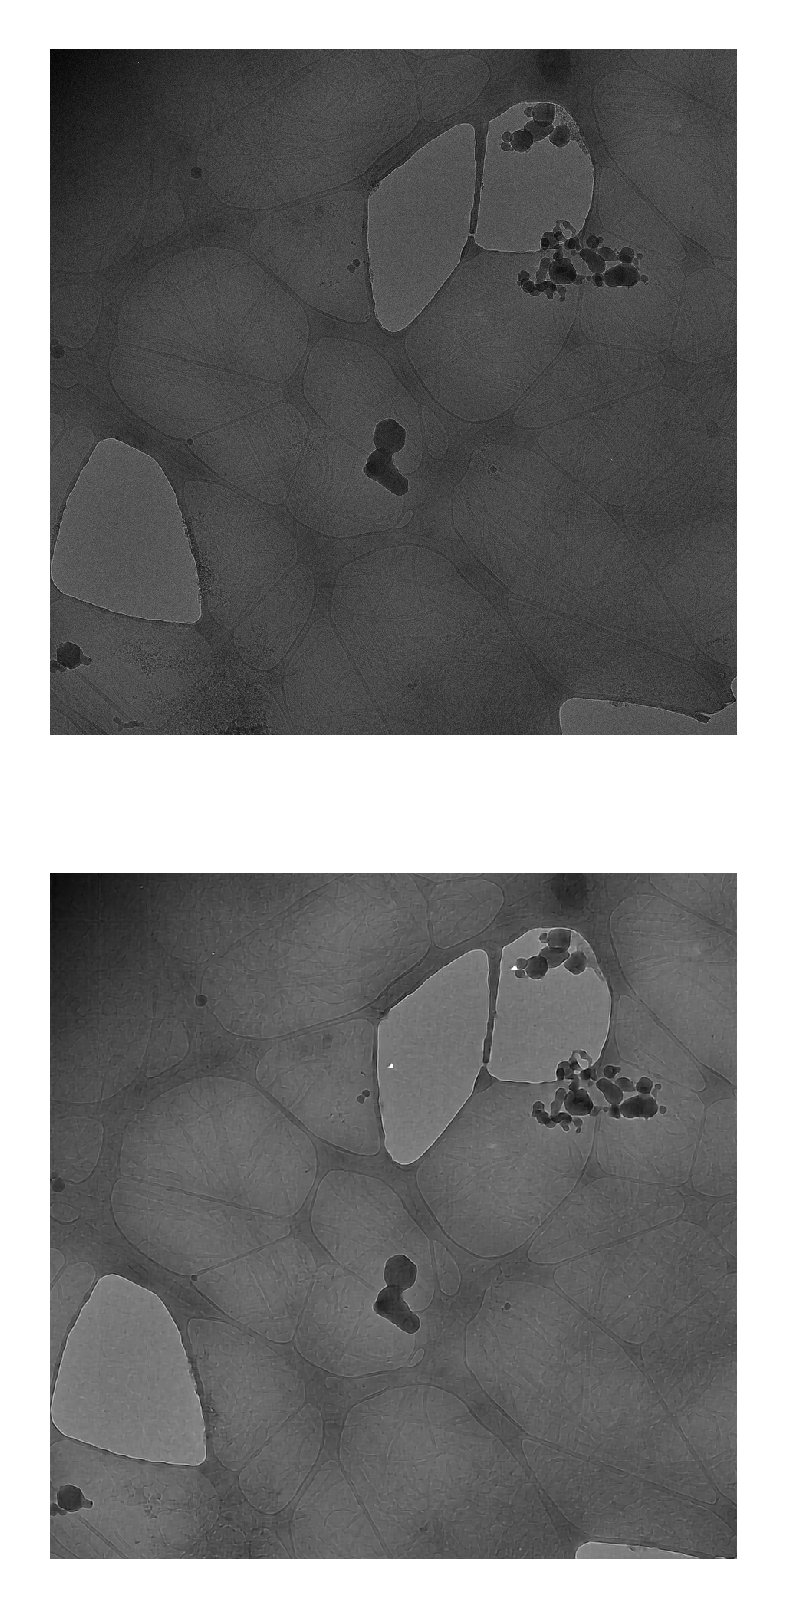

In [68]:
fig, ax = plt.subplots(2,1)
ax = ax.flatten()
fig.set_dpi(500)
ax[0].axis('off')
ax[0].imshow(big_test, cmap='gray')
ax[1].axis('off')
ax[1].imshow(big_pred, cmap='gray')
#plot both the original and the predicted image

To determine if the autoencoder is good enough, make sure that features you want classify (ex. filaments) are clearly visible in the predicted image, as that will determine whether the latent space encoding is good enough.